# !pip install torch
# !pip install torchvision

In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3                           # Number of epochs to train
batch_size_train = 64                  # Size of batch for trianing, hardware dependant usually
batch_size_test = 1000                 # Testing (no gradient) can have bigger batches
learning_rate = 0.01                   # LR
momentum = 0.5                         # 
log_interval = 10                      # How much logging

random_seed = 1                        # Can repeat experiments 
torch.backends.cudnn.enabled = False   # NO GPU
torch.manual_seed(random_seed)         # Can repeat experiments

# Data Loader

Pytorch uses DataLoaders as a data provider for the computations to be done (on GPU/CPU).


In our case, the DataLoader receives a dataset (from torchvision). 

The dataset is MNIST (a standard vision dataset with handwritten numbers). 

Our parameters:
- train: if using the train or test part of the dataset
- transforms: a composition of several transformations to apply to the data
  - ToTensor
  - Normalize (mean, std)

Dataloader params:
- batch_size
- shuffle: randomize order

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)


In [4]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

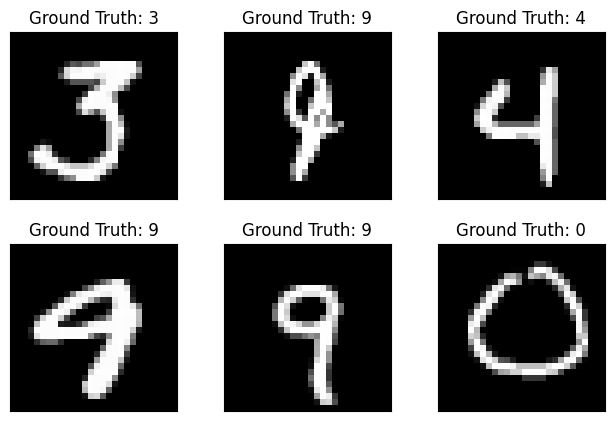

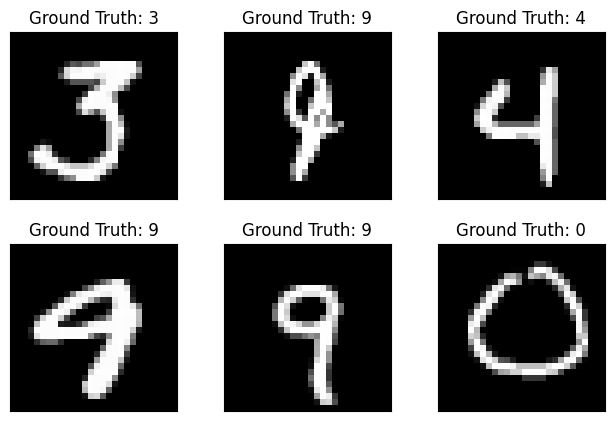

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Define the Neural Network, as a subclass de nn.Module 

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Convolutional Layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Dropout 
        self.conv2_drop = nn.Dropout2d()
        # Linear layer
        self.fc1 = nn.Linear(320, 50)
        # Linear layer
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Forward pass 1st layer: convolutional -> max_pool2d -> RELU
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Forward pass 1st layer: convolutional -> dropout -> max_pool2d -> RELU
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # RESHAPE THE TENSOR to x,320
        x = x.view(-1, 320)
        # Forward pass: linear -> relu
        x = F.relu(self.fc1(x))
        # DROPOUTT
        x = F.dropout(x, training=self.training)
        # Forward pass; linear
        x = self.fc2(x)
        # Activation F: log_softmax
        return F.log_softmax(x)

Create the NeuralNetwork

In [10]:
network = Net()


Add and optimizer (for training), Stochastig Gradient Descent

In [11]:
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# Train 



In [13]:
def train(epoch):
  # Set the model in train mode
  network.train()
  # For all batches
  for batch_idx, (data, target) in enumerate(train_loader):
    # Clear the gradient optimizer
    optimizer.zero_grad()
    # Compute the network output
    output = network(data)
    # Compute the loss (error)
    loss = F.nll_loss(output, target)
    # Propagate the loss (train)
    loss.backward()
    # Use SGD to train
    optimizer.step()
    # Periodically, log and print
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

# Test

Works mostly like train With no_grad

In [14]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# Train loop

First we "test" (to check/print status). 

In [15]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/var/folders/c6/2fy4cjy95j728_dptd00ljy00000gn/T/ipykernel_2200/3597232830.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/Users/jordilazo/Library/Python/3.9/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281435
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.243744
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264606
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240564
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153203
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.211479
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.056642
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.010620
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.008978
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.867196
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.755030
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.617570
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.411560
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.595002
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.259322
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.326811
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.236616
Train Epoch: 1 [12160/6

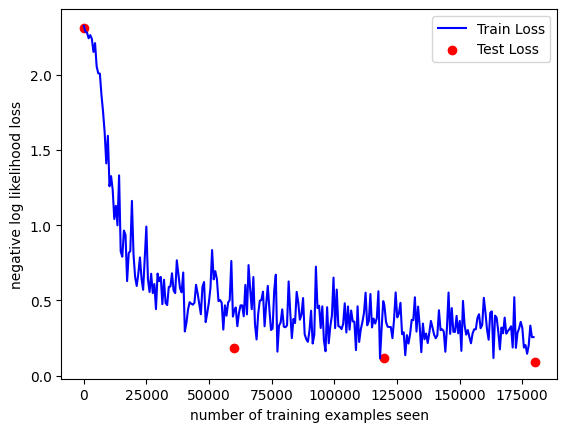

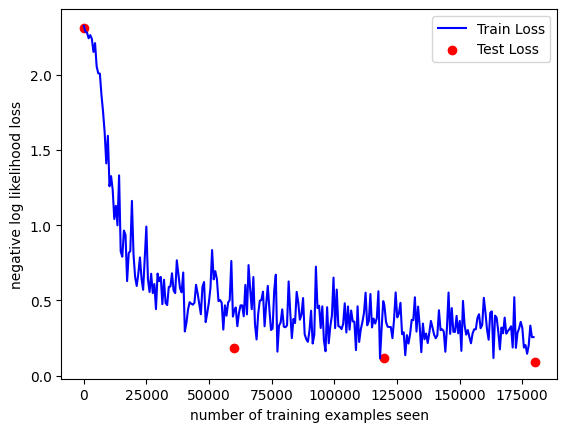

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [17]:
with torch.no_grad():
  output = network(example_data)

/var/folders/c6/2fy4cjy95j728_dptd00ljy00000gn/T/ipykernel_2200/3597232830.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


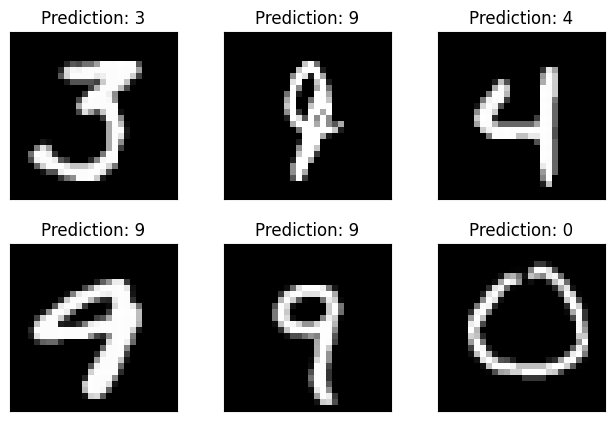

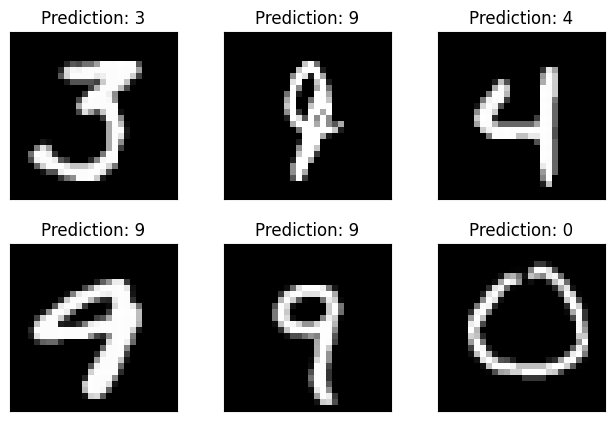

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [19]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [20]:
network_state_dict = torch.load("results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)


In [21]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/var/folders/c6/2fy4cjy95j728_dptd00ljy00000gn/T/ipykernel_2200/3597232830.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.347035
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.296893
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.269686
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.191859
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.281953
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.227349
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.378156
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.384605
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.252886
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.183499
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.388906
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.281775
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.154732
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.169704
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.228795
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.206363
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.161869
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.112063
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.452519
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.222703
Train Epoch: 4 [12800/60000 (

Text(0, 0.5, 'negative log likelihood loss')

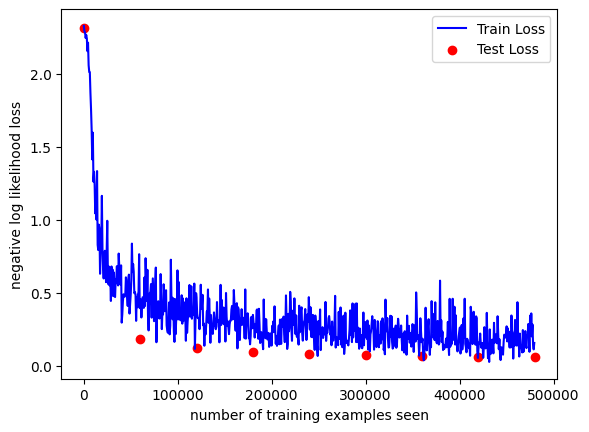

In [23]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# fig